<h3>Getting started with Python and the Jupyter Notebook</h3>

Welcome to your first jupyter notebook. The notebook is an excellent playground to test your code. The advantage of notebooks is that they can include text, code, and plots in the same document.
Don't close the terminal where you started "jupyter notebook". That's where the python kernel is running.

To start, you will first need the netcdf file we'll be working with. Download it to whatever folder you like by typing into your command line (use a new terminal):

<tt> $ wget --http-user=amma2050 --http-passwd=@Amma2050! http://amma2050.ipsl.upmc.fr/CMIP5_AFRICA/mdlgrid/HadGEM2-ES/historical/pr_day_HadGEM2-ES_africa_historical_r1i1p1_full.nc 

To navigate through the notebook, use:
* <b>shift + enter</b> to execute a notebook cell and move the cursor down
* <b>alt + enter</b> to execute a notebook cell and create a new cell below
* <b>ctrl + enter</b> to execute a notebook cell in place

To go through this notebook, try <b>shift + enter</b>.
For more shortcuts, check the help dropdown menu at the top right -> keyboard shortcuts

In [1]:
print("Let's start!")

Let's start!


First, we need to load all the Python packages we are going to use. In Python, every package needs to be imported in the script where you want to use it. That makes it easy for everybody to understand what is needed to actually run your code:

In [1]:
import os
import iris    #  handling cubes of big data
import iris.coord_categorisation  # allows you to add new coordinates to your data cube
import iris.plot as iplt # a quickplot option from the Iris package
import iris.quickplot as qplt

import matplotlib.pyplot as plt # the package doing the plotting
import datetime # handles dates

import cartopy  # helps to create maps
import cartopy.crs as ccrs # helps to create maps
import numpy as np  # handles arrays
# this makes sure that your plots pop up in the notebook and no extra window is opened: 
%matplotlib inline  
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size
np.set_printoptions(threshold=20)  # avoid to print very large arrays on screen

Adjust the "path" variable to point to the file that you just downloaded. No need to change the "file" variable! :

In [2]:
path ='/nfs/a266/data/CMIP5_AFRICA/mdlgrid/HadGEM2-ES/historical/'
file = 'tas_day_HadGEM2-ES_africa_historical_r1i1p1_full.nc'
if os.path.isfile(file):
    print 'The file exists!'

In [3]:
iris.FUTURE.netcdf_promote = True

Remember to use <b>alt + enter</b> to execute every cell!
We'll now load the netcdf file with the Iris package:

In [4]:
cubes = iris.load(path+file)

Print some information on what we got:

In [13]:
print(cubes)

0: air_temperature / (K)               (time: 20160; latitude: 65; longitude: 40)


So we're looking at precipitation data for 20160 time steps. Iris just read a [time, latitude, longitude] cube! <br>
Be careful, the python coordinate convention for arrays is [z, y, x], so time is our first dimension. <br>
Let's do a quick plot:

<type 'netcdftime._datetime.datetime'>
1950-01-01
<type 'netcdftime._datetime.datetime'>
1950-01-02
<type 'netcdftime._datetime.datetime'>
1950-01-03
<type 'netcdftime._datetime.datetime'>
1950-01-04
<type 'netcdftime._datetime.datetime'>
1950-01-05
<type 'netcdftime._datetime.datetime'>
1950-01-06


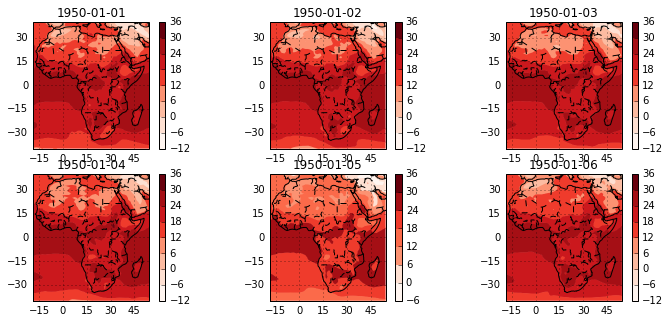

In [47]:
f=plt.figure()   # open a figure
for t in range(6):   # start loop of 0,1,2,3 - python neglects the last step in ranges! 
    # specify plot axis with projection. 2,2,t+1 means a 2x2 plot with t+1 being the current plot index. 
    ax = f.add_subplot(2,3,t+1, projection=ccrs.PlateCarree()) 
    brewer_cmap = plt.cm.get_cmap('brewer_Reds_09')
    iplt.contourf(cubes[0][t,:,:]-273.5, cmap=brewer_cmap)  # filled contour plot
    tc=cubes[0][t,:,:].coord('time')
    my_units=tc.units
    a=my_units.num2date(tc.points[0])
    print type(a)
    print a.strftime('%Y-%m-%d')
    ax.set_title(a.strftime('%Y-%m-%d'))
    ax.coastlines()  # add coastlines to axis
    # Gridlines
    xl = ax.gridlines(draw_labels=True) # draw gridlines
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
    plt.colorbar()
plt.show()

What we just did: we took the cube with index 0 (see print(cube)), which is the precipitation flux, and plotted the first four time steps ([t, :, :] with iterating t) of it. This file only contains precip, but in principle, we could have several cubes in our file. Let's get more information on the precipitation data and extract its cube:

In [32]:
precip = cubes[0] # extract
print(precip)

air_temperature / (K)               (time: 20160; latitude: 65; longitude: 40)
     Dimension coordinates:
          time                           x                -              -
          latitude                       -                x              -
          longitude                      -                -              x
     Attributes:
          CDI: Climate Data Interface version 1.6.8 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.8 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM2-ES_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.0
          comment: daily-mean near-surface (usually, 2 meter) air temperature.
          contact: chris.d.jones@metoffice.gov.uk, michael.sanderson@metoffice.gov.uk
          creation_date: 2010-11-22T15:34:22Z
          experiment: historical
          ex

And some time info - print first and last time step: the data is from 1950 to 2005 with daily steps (see bounds)

In [97]:
time=precip.coord('time')
print(time[0])
print(time[-1])

DimCoord([1950-01-01 12:00:00], bounds=[[1950-01-01 00:00:00, 1950-01-02 00:00:00]], standard_name=u'time', calendar=u'360_day', long_name=u'time', var_name='time')
DimCoord([2005-12-30 12:00:00], bounds=[[2005-12-30 00:00:00, 2006-01-01 00:00:00]], standard_name=u'time', calendar=u'360_day', long_name=u'time', var_name='time')


We saw that our data encompasses the whole of Africa but we want to concentrate on West Africa so we want a subset. <br> When you want to extract a subset with Iris you have to define constraints for the data coordinates:

In [33]:
WA_lat=iris.Constraint(latitude=lambda cell: 4 <= cell <= 25.0) # latitude constraint 4-25N
WA_lon=iris.Constraint(longitude=lambda cell: -18 <= cell <= 25.0) # longitude constraint 18W - 25E

Lambda what? Exactly.. looks complicated but basically, lambda allows you to define a mini function within the call of another function, in this case iris.Constraint. Lambda allows you to pass functions like a normal variable. If you want to know more about how lambda functions work, have a look here: http://www.diveintopython.net/power_of_introspection/lambda_functions.html

We now apply the constraint to our cube and convert the precipitation flux (mm s-1) to mm per day

In [34]:
precip = precip.extract(WA_lat & WA_lon) # apply constraints
precip.convert_units('Celsius')  # convert unit

In [9]:
#a more simplier way of getting westa africa
precip=precip.intersection(latitude=(9.0, 10.0), longitude=(0, 5))
#precip.convert_units('kg m-2 d-1')  # convert unit
precip.convert_units('Celsius')  # convert unit
print(precip)
qplt.contourf(precip[1])
plt.show()

ValueError: coordinate's range greater than coordinate's unit's modulus

In [104]:
print precip.coord('longitude')

DimCoord(array([-18.75 , -16.875, -15.   , ...,  50.625,  52.5  ,  54.375]), bounds=array([[ 340.3125,  -17.8125],
       [ 342.1875,  -15.9375],
       [ 344.0625,  -14.0625],
       ..., 
       [ 409.6875,   51.5625],
       [ 411.5625,   53.4375],
       [ 413.4375,   55.3125]]), standard_name=u'longitude', units=Unit('degrees'), long_name=u'longitude', var_name='lon')


As an example, we want to compute the 95th percentile of our rainfall per month per pixel over all years. For this, we add a monthly coordinate to our cube in order to be able to aggregate the data by month

In [12]:
# Add the month coordinate
iris.coord_categorisation.add_month_number(precip, 'time', name='month')

We can now aggregate by the new coordinate "month" and compute the 95th percentile (just ignore the Deprecation warning)

In [13]:
perc = precip.aggregated_by('month', iris.analysis.PERCENTILE, percent=95)

What is perc? Have a look at the time coordinate now!

In [14]:
print(perc)

air_temperature / (Celsius)         (time: 12; latitude: 18; longitude: 23)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Auxiliary coordinates:
          month                          x             -              -
     Scalar coordinates:
          percentile_over_month: 95
     Attributes:
          CDI: Climate Data Interface version 1.6.8 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.8 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM2-ES_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.0
          comment: daily-mean near-surface (usually, 2 meter) air temperature.
          contact: chris.d.j

Let's quickplot August - so index 7 from our 12 months. This time it's our West Africa sub-domain!

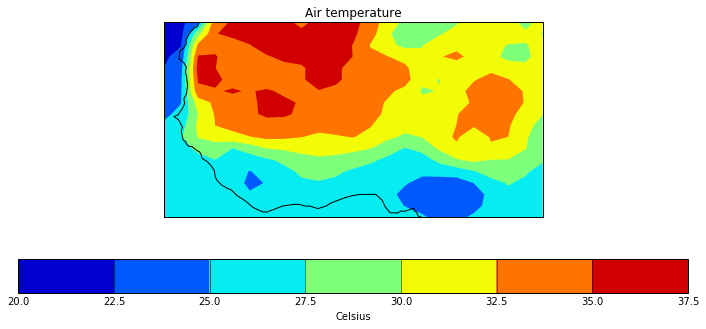

In [22]:
qplt.contourf(perc.extract(iris.Constraint(month=7)))
d = plt.gca() # get axis object
d.coastlines() # to draw coastlines

Now we want to check the number of days > 10 mm day-1 per pixel over all years - we collapse the cube over the time coordinate and count the >10 occurrences with the iris.analysis.COUNT function

In [26]:
bigger = precip.collapsed('time', iris.analysis.COUNT, function = lambda values: values > 18 )

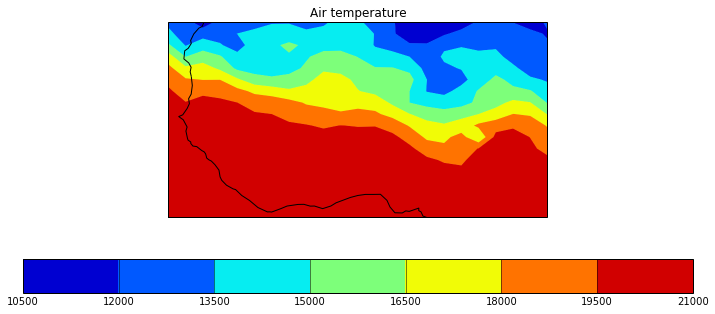

In [27]:
qplt.contourf(bigger)
d = plt.gca() # get axis object
d.coastlines() # to draw coastlines

In [43]:
val=5
bigger = precip.aggregated_by('month', iris.analysis.COUNT, function = lambda values: values > val )


In [44]:
print precip

air_temperature / (Celsius)         (time: 20160; latitude: 18; longitude: 23)
     Dimension coordinates:
          time                           x                -              -
          latitude                       -                x              -
          longitude                      -                -              x
     Auxiliary coordinates:
          month                          x                -              -
     Attributes:
          CDI: Climate Data Interface version 1.6.8 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.8 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM2-ES_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.0
          comment: daily-mean near-surface (usually, 2 meter) air temperature.
          contact: chris.d.jones@metoffice.gov.uk, michael.sanderson@metof

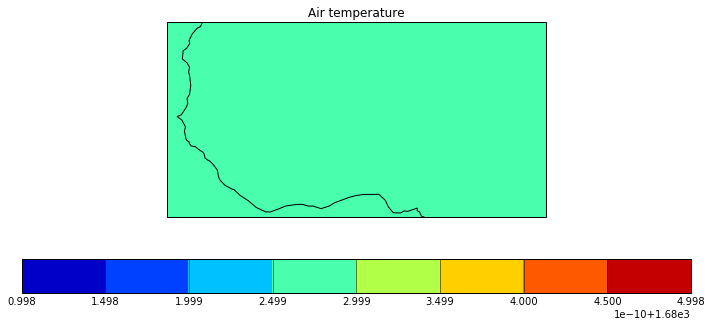

In [46]:
qplt.contourf(bigger[6])
d = plt.gca() # get axis object
d.coastlines() # to draw coastlines

To make it a bit more complicated, we now want to compute the number of dry spells. For this, we write a small function, since Iris can't compute this by default. The function takes our data (precip), the rainfall threshold we want to count as "wet day" and the length of dry days we want to consider as "dry spell":

In [28]:
percm = precip.aggregated_by('month', iris.analysis.MEAN)
print(percm)

air_temperature / (Celsius)         (time: 12; latitude: 18; longitude: 23)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Auxiliary coordinates:
          month                          x             -              -
     Attributes:
          CDI: Climate Data Interface version 1.6.8 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.8 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM2-ES_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.0
          comment: daily-mean near-surface (usually, 2 meter) air temperature.
          contact: chris.d.jones@metoffice.gov.uk, michael.sanderson@metoffice.gov.uk
   

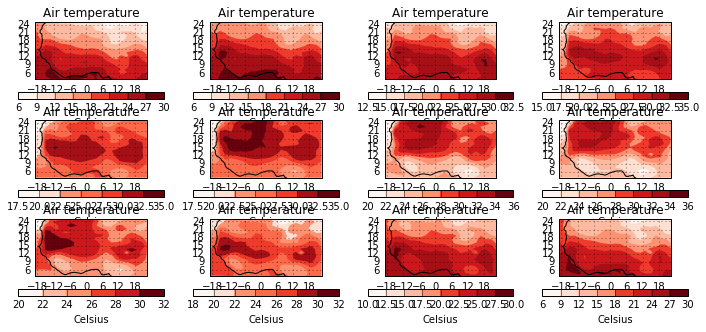

In [29]:
f=plt.figure()   # open a figure
for t in range(12):   # start loop of 0,1,2,3 - python neglects the last step in ranges! 
    # specify plot axis with projection. 2,2,t+1 means a 2x2 plot with t+1 being the current plot index. 
    ax = f.add_subplot(3,4,t+1, projection=ccrs.PlateCarree()) 
    brewer_cmap = plt.cm.get_cmap('brewer_Reds_09')
    qplt.contourf(percm[t], cmap=brewer_cmap)
    d = plt.gca() # get axis object
    d.coastlines() # to draw coastlines, cmap=brewer_cmap)  # filled contour plot
   # ax.coastlines()  # add coastlines to axis
    # Gridlines
    xl = ax.gridlines (draw_labels=True) # draw gridlines
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    #ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
    #plt.colorbar()
plt.show()

ValueError: Cube must be 2-dimensional. Got 3 dimensions.

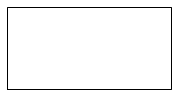

In [81]:
#plot JJA mean temperature over west africa
f=plt.figure()   # open a figure
for t in np.arange(6,9):   # start loop of 0,1,2,3 - python neglects the last step in ranges! 
    # specify plot axis with projection. 2,2,t+1 means a 2x2 plot with t+1 being the current plot index. 
    ax = f.add_subplot(3,1,t+1, projection=ccrs.PlateCarree()) 
    brewer_cmap = plt.cm.get_cmap('brewer_Reds_09')
    qplt.contourf(percm[t,:,:], cmap=brewer_cmap)
    d = plt.gca() # get axis object
    d.coastlines() # to draw coastlines, cmap=brewer_cmap)  # filled contour plot
   # ax.coastlines()  # add coastlines to axis
    # Gridlines
    xl = ax.gridlines (draw_labels=True) # draw gridlines
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    #ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
    #plt.colorbar()
plt.show()

In [264]:
def count_spells(data, threshold, axis, spell_length):
    #print(data.shape)
    #print(axis)
    if axis < 0:
        # just cope with negative axis numbers
        axis += data.ndim
    #print(axis)    
    # Threshold the data to find the 'significant' points.
    data_hits = data < threshold
    # Make an array with data values "windowed" along the time axis.
    hit_windows = iris.util.rolling_window(data_hits, window=spell_length, axis=axis) # rolling window along time axis
    #print(hit_windows.shape)
    # Find the windows "full of True-s" (along the added 'window axis').
    full_windows = np.all(hit_windows, axis=axis+1)
    # Count points fulfilling the condition (along the time axis).
    spell_point_counts = np.sum(full_windows, axis=axis, dtype=int)
    return spell_point_counts

The "iris.analysis.Aggregator" is used to implement user-made aggregation functions into the Iris framework. 

In [265]:
 # Make an aggregator from dry spell count user function
count = iris.analysis.Aggregator('spell_count',count_spells,
                                 units_func=lambda units: 1)


We define our minimum rainfall per day to be 1mm and the threshold for a day spell to be 6 days. We then compute the metric over the 'time' coordinate with our newly defined aggregator "count":

In [266]:
# Define the parameters of the aggregation:
thresh_rain = 1
spell_days = 6

# Calculate the statistic.
dry_spell = precip.collapsed('time', count,threshold=thresh_rain,
                                      spell_length=spell_days)
dry_spell.rename('Number of days with rain < 1mm day-1 over 6 consecutive days')

C:\Miniconda3\lib\site-packages\iris\coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Miniconda3\lib\site-packages\iris\coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


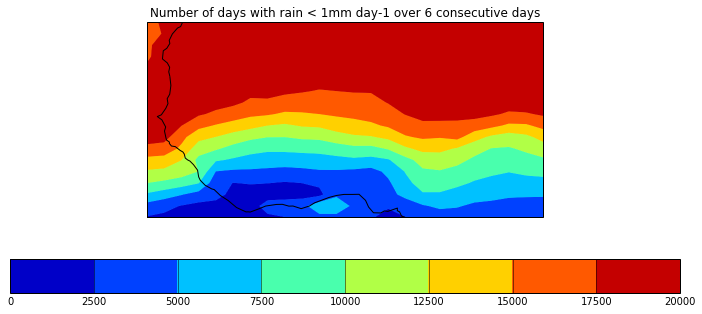

In [267]:
qplt.contourf(dry_spell)
d = plt.gca() # get axis object
d.coastlines() # to draw coastlines

As a last excercise, let's compute the annual mean. For this, we add a year coordinate just like we did for the months and then average the precipitation with iris.analysis.MEAN (again, ignore the errors..)

In [242]:
iris.coord_categorisation.add_year(precip, 'time', name='year')
# Quick mean temperature
p_mean = precip.aggregated_by(['year'], iris.analysis.MEAN)

C:\Miniconda3\lib\site-packages\iris\coords.py:495: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).
  bounds = bounds[keys + (Ellipsis, )]


Let's also compute the domain-wide precipitation average per year:

In [243]:
pmean_domain=p_mean.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

C:\Miniconda3\lib\site-packages\iris\cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


And now, let's plot everything we did so far in one multiplot, just for fun. Here you also see how to define a new colormap for example or how to add country borders:

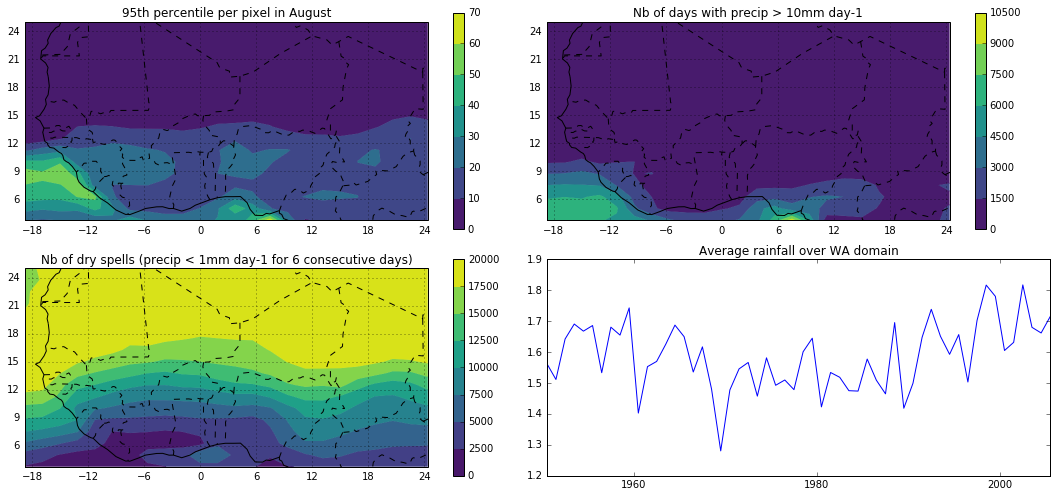

In [244]:
fig = plt.figure(figsize=(15,7), dpi=300)
ax=fig.add_subplot(2,2,1 , projection=ccrs.PlateCarree())
iplt.contourf(perc[7], cmap='viridis')
plt.title('95th percentile per pixel in August')
ax.coastlines()
# Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
plt.colorbar()
    
ax=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
iplt.contourf(bigger, cmap='viridis')
plt.title('Nb of days with precip > 10mm day-1')
ax.coastlines()
# Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
plt.colorbar()

ax=fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
iplt.contourf(dry_spell, cmap='viridis')
plt.title('Nb of dry spells (precip < 1mm day-1 for 6 consecutive days)')
ax.coastlines()
# Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
plt.colorbar()

ax = fig.add_subplot(2, 2, 4)
iplt.plot(pmean_domain)
plt.title('Average rainfall over WA domain')

plt.tight_layout()
plt.show()

For all your open questions, always search for the documentation website for the python package you are dealing with first. Detailed information with lots of examples for Iris, scipy, numpy and whatever package you stumble into can be found online. Solutions for very specific questions are often answered in detail in one of the many python forums. 